In [1]:
# Needed for literally anything
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import fasteda as eda # my recent favorite all-in-one EDA module
import branca.colormap as cm

# machine learning
# from sklearn.impute import SimpleImputer, IterativeImputer
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GroupKFold, cross_val_score
# from skopt import BayesSearchCV, Real, Integer, Categorical, make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.experimental import enable_iterative_imputer

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/playground-series-s3e20/sample_submission.csv
/kaggle/input/playground-series-s3e20/train.csv
/kaggle/input/playground-series-s3e20/test.csv


## Importing Data:

In [2]:
train = pd.read_csv("/kaggle/input/playground-series-s3e20/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s3e20/test.csv")
sample_submission = pd.read_csv("/kaggle/input/playground-series-s3e20/sample_submission.csv")

## Data Analysis: Let's start with the "train" dataset first. 

In [3]:
train.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,SulphurDioxide_solar_azimuth_angle,SulphurDioxide_solar_zenith_angle,SulphurDioxide_SO2_column_number_density_15km,CarbonMonoxide_CO_column_number_density,CarbonMonoxide_H2O_column_number_density,CarbonMonoxide_cloud_height,CarbonMonoxide_sensor_altitude,CarbonMonoxide_sensor_azimuth_angle,CarbonMonoxide_sensor_zenith_angle,CarbonMonoxide_solar_azimuth_angle,CarbonMonoxide_solar_zenith_angle,NitrogenDioxide_NO2_column_number_density,NitrogenDioxide_tropospheric_NO2_column_number_density,NitrogenDioxide_stratospheric_NO2_column_number_density,NitrogenDioxide_NO2_slant_column_number_density,NitrogenDioxide_tropopause_pressure,NitrogenDioxide_absorbing_aerosol_index,NitrogenDioxide_cloud_fraction,NitrogenDioxide_sensor_altitude,NitrogenDioxide_sensor_azimuth_angle,NitrogenDioxide_sensor_zenith_angle,NitrogenDioxide_solar_azimuth_angle,NitrogenDioxide_solar_zenith_angle,Formaldehyde_tropospheric_HCHO_column_number_density,Formaldehyde_tropospheric_HCHO_column_number_density_amf,Formaldehyde_HCHO_slant_column_number_density,Formaldehyde_cloud_fraction,Formaldehyde_solar_zenith_angle,Formaldehyde_solar_azimuth_angle,Formaldehyde_sensor_zenith_angle,Formaldehyde_sensor_azimuth_angle,UvAerosolIndex_absorbing_aerosol_index,UvAerosolIndex_sensor_altitude,UvAerosolIndex_sensor_azimuth_angle,UvAerosolIndex_sensor_zenith_angle,UvAerosolIndex_solar_azimuth_angle,UvAerosolIndex_solar_zenith_angle,Ozone_O3_column_number_density,Ozone_O3_column_number_density_amf,Ozone_O3_slant_column_number_density,Ozone_O3_effective_temperature,Ozone_cloud_fraction,Ozone_sensor_azimuth_angle,Ozone_sensor_zenith_angle,Ozone_solar_azimuth_angle,Ozone_solar_zenith_angle,UvAerosolLayerHeight_aerosol_height,UvAerosolLayerHeight_aerosol_pressure,UvAerosolLayerHeight_aerosol_optical_depth,UvAerosolLayerHeight_sensor_zenith_angle,UvAerosolLayerHeight_sensor_azimuth_angle,UvAerosolLayerHeight_solar_azimuth_angle,UvAerosolLayerHeight_solar_zenith_angle,Cloud_cloud_fraction,Cloud_cloud_top_pressure,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
0,ID_-0.510_29.290_2019_00,-0.51,29.29,2019,0,-0.000108,0.603019,-0.000065,0.255668,-98.593887,50.843559,-130.050797,35.874496,-0.000027,0.035370,1589.024536,4061.098145,829530.500000,71.111977,52.775928,-149.875565,25.965214,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000117,0.863230,0.000038,0.255668,35.874496,-130.050797,50.843559,-98.593887,-1.280761,829864.546875,-12.628979,35.632416,-138.786446,30.752128,0.115927,2.506609,0.295663,225.731144,0.595473,-12.628979,35.632416,-138.786446,30.752128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.595473,53534.732422,3664.436218,61085.809570,2615.120483,15.568533,0.272292,-12.628986,35.632416,-138.786423,30.752140,3.750994
1,ID_-0.510_29.290_2019_01,-0.51,29.29,2019,1,0.000021,0.728214,0.000014,0.130988,16.592861,39.137194,-140.874435,28.965133,0.000012,0.036526,1772.574405,1869.040414,829787.287130,-1.019594,38.982368,-140.158048,29.562000,0.000047,1.639765e-05,0.00003,0.000093,7311.869141,-1.935386,0.067038,829859.960368,5.471037,35.265195,-138.343908,30.054262,0.000170,1.172826,0.000143,0.200754,29.071781,-141.814827,43.050213,4.678839,-1.548119,829747.856973,16.152492,43.485327,-142.786141,28.573627,0.116775,2.657704,0.315733,226.172170,0.175166,24.464335,42.596541,-143.097868,28.213655,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.213608,63790.296241,3651.190311,66969.478735,3174.572424,8.690601,0.256830,30.359375,39.557633,-145.183930,27.251779,4.025176
2,ID_-0.510_29.290_2019_02,-0.51,29.29,2019,2,0.000514,0.748199,0.000385,0.110018,72.

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79023 entries, 0 to 79022
Data columns (total 76 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   ID_LAT_LON_YEAR_WEEK                                      79023 non-null  object 
 1   latitude                                                  79023 non-null  float64
 2   longitude                                                 79023 non-null  float64
 3   year                                                      79023 non-null  int64  
 4   week_no                                                   79023 non-null  int64  
 5   SulphurDioxide_SO2_column_number_density                  64414 non-null  float64
 6   SulphurDioxide_SO2_column_number_density_amf              64414 non-null  float64
 7   SulphurDioxide_SO2_slant_column_number_density            64414 non-null  float64
 8   SulphurDioxide_c

#### No categorical data 😍😍😍😍. Hence no need for transformation stuff. 

### Next, I grouped the features by their first word. I thought of this as useful for understanding the data and for selecting the features that I want to use for my model.

* For example, the CarbonMonoxide feature measures the amount of carbon monoxide in the atmosphere. The Cloud feature measures the amount of cloud cover in the atmosphere. The Formaldehyde feature measures the amount of formaldehyde in the atmosphere.
* Another example: if you are interested in predicting the amount of ozone in the atmosphere, you may want to focus on the Ozone feature and the features that are related to ozone, such as the UvAerosolIndex feature.

In [5]:
def get_first_word(col):
    return col.split('_')[0]

grouped_features = {get_first_word(col) for col in train.columns}
print(grouped_features)

{'Formaldehyde', 'emission', 'ID', 'Cloud', 'NitrogenDioxide', 'UvAerosolIndex', 'Ozone', 'UvAerosolLayerHeight', 'CarbonMonoxide', 'year', 'week', 'latitude', 'longitude', 'SulphurDioxide'}


#### Let's check for null values (common in all data analysis):

In [6]:
missing = train.isnull().sum()
missing[missing > 0].sort_values(ascending=False).head(20)

UvAerosolLayerHeight_aerosol_pressure                      78584
UvAerosolLayerHeight_solar_zenith_angle                    78584
UvAerosolLayerHeight_aerosol_height                        78584
UvAerosolLayerHeight_aerosol_optical_depth                 78584
UvAerosolLayerHeight_sensor_zenith_angle                   78584
UvAerosolLayerHeight_sensor_azimuth_angle                  78584
UvAerosolLayerHeight_solar_azimuth_angle                   78584
NitrogenDioxide_NO2_slant_column_number_density            18320
NitrogenDioxide_tropopause_pressure                        18320
NitrogenDioxide_tropospheric_NO2_column_number_density     18320
NitrogenDioxide_absorbing_aerosol_index                    18320
NitrogenDioxide_cloud_fraction                             18320
NitrogenDioxide_sensor_altitude                            18320
NitrogenDioxide_sensor_azimuth_angle                       18320
NitrogenDioxide_sensor_zenith_angle                        18320
NitrogenDioxide_solar_azi

#### "UvAerosolLayerHeight" columns have the highest values of missing data. This can be removed later on during feature engineering steps.

In [7]:
# Number of missing values for each year
train.isnull().groupby(train['year']).sum().sum(axis=1)

year
2019    309254
2020    333338
2021    347499
dtype: int64

#### The output shows that there are no missing values for the years 2019 and 2021. However, there are missing values for the year 2020. There are a total of 33333 missing values for the year 2020.

In [8]:
train[['year', 'emission']].describe()

,year,emission
count,79023.000000,79023.000000
mean,2020.000000,81.940552
std,0.816502,144.299648
min,2019.000000,0.000000
25%,2019.000000,9.797995
50%,2020.000000,45.593445
75%,2021.000000,109.549595
max,2021.000000,3167.768000


## EDA Time:

In [ ]:
# from fasteda import fast_eda
# fast_eda(train)

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


50th percentile: 45.59
95th percentile: 266.48


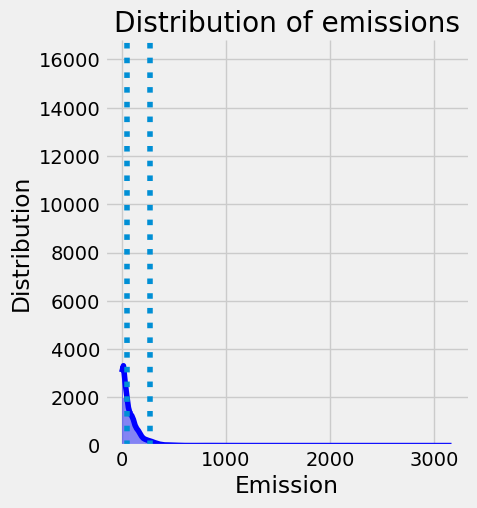

In [9]:
# Create a copy of the DataFrame for plotting
train_plot = train.copy()

# Add a date column
train_plot['date'] = pd.to_datetime(train_plot['year'].astype(str) + '-' + train_plot['week_no'].astype(str) + '-1', format='%Y-%W-%w')

# Plot the distribution of the emission
sns.displot(train_plot['emission'], kde=True, color='blue')

# Add vertical lines at the 50th and 95th percentiles
q50 = train_plot['emission'].quantile(0.5)
q95 = train_plot['emission'].quantile(0.95)
plt.axvline(q50, linestyle=':')
plt.axvline(q95, linestyle=':')

# Customize the plot
plt.xlabel('Emission')
plt.ylabel('Distribution')
plt.title('Distribution of emissions')

# Print the 50th and 95th percentile values
print('50th percentile: {:.2f}'.format(q50))
print('95th percentile: {:.2f}'.format(q95))

plt.show()

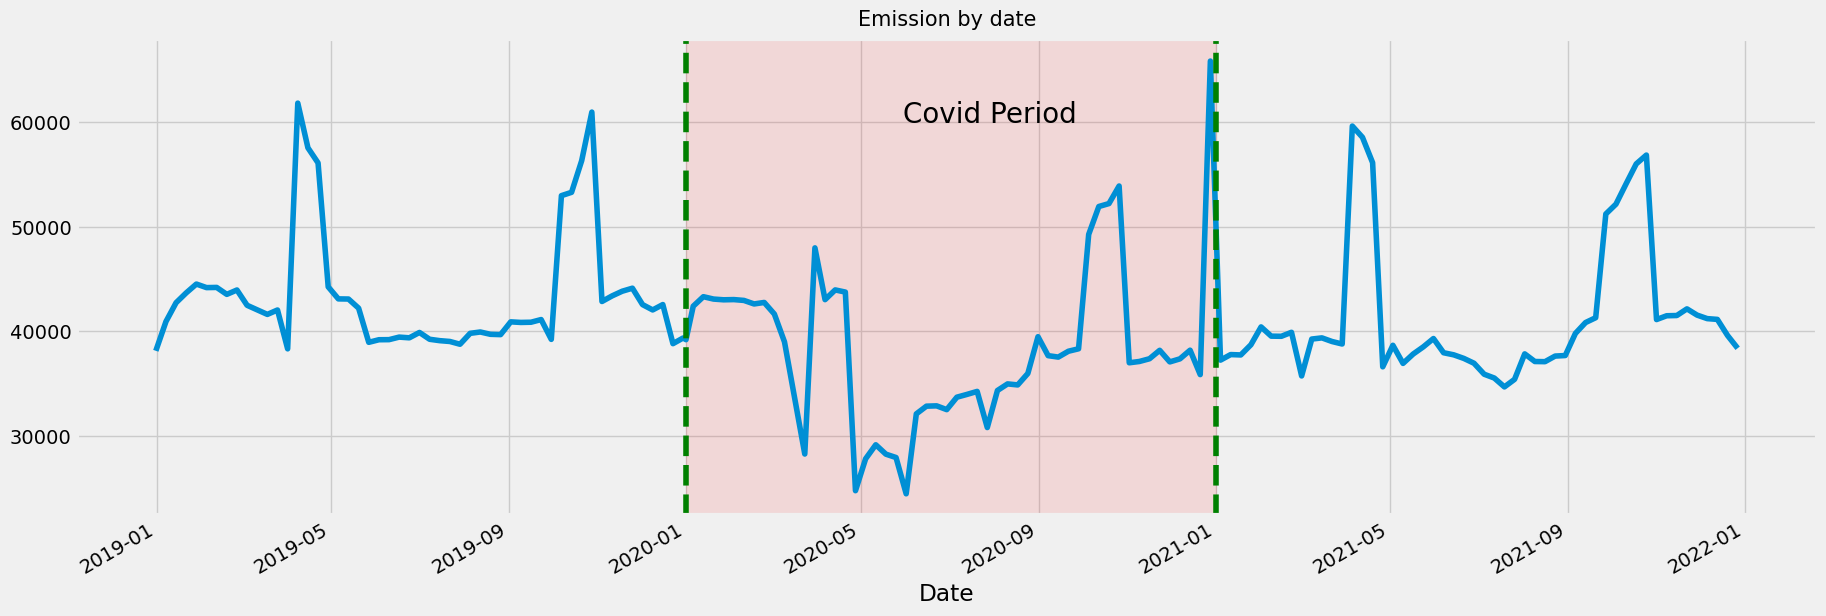

In [10]:
train_plot.groupby(['date'])['emission'].sum().plot(kind='line', figsize=(20, 7), xlabel='Date')

plt.axvspan(pd.Timestamp('2020-01-01'), pd.Timestamp('2021-01-01'), color='red', alpha=0.1)
plt.axvline(pd.Timestamp('2020-01-01'), linestyle = "--", color='green')
plt.axvline(pd.Timestamp('2021-01-01'), linestyle = "--", color='green')

plt.text(pd.Timestamp ('2020-05-30'), 60000, "Covid Period", size = 20)

plt.title('Emission by date', size=15, pad=10)
plt.show()

#### As expected, emissions has been lower in the "Covid-19" era.

/tmp/ipykernel_1929/1926409297.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels([2019, 2021])


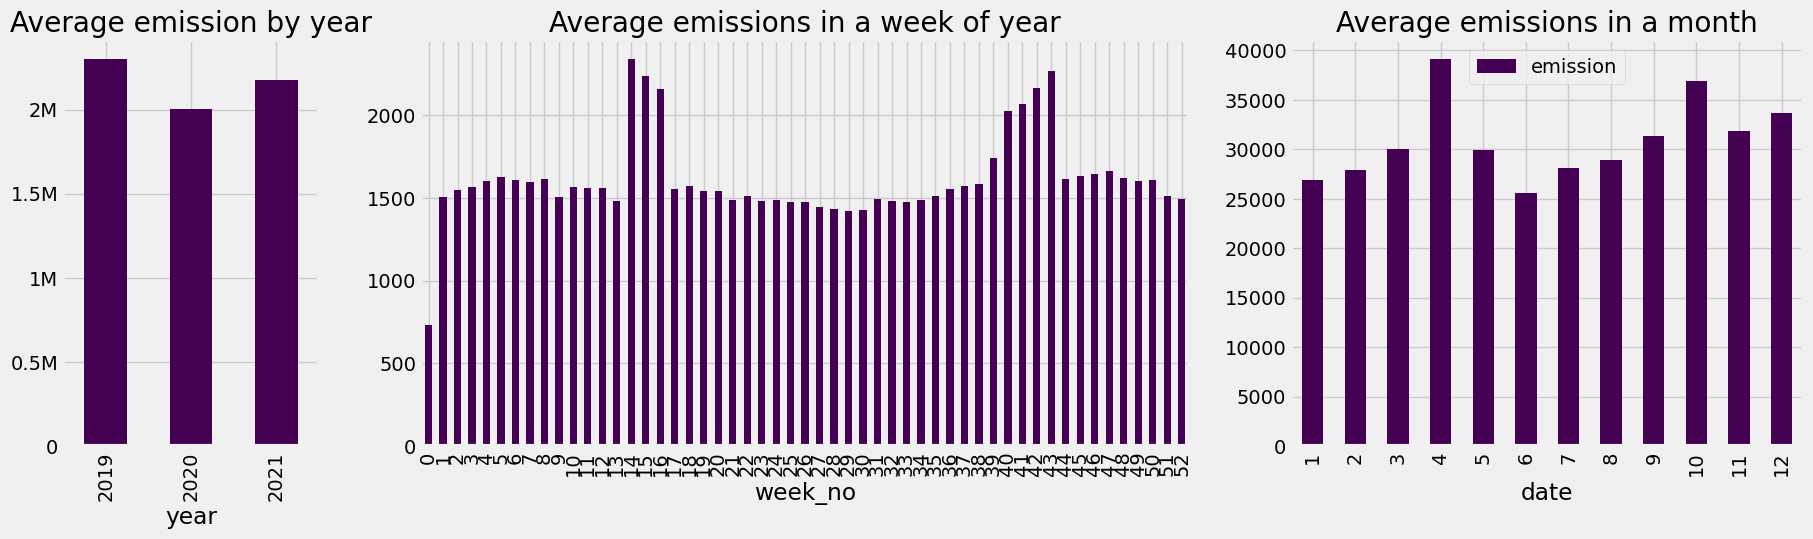

In [11]:
# Removing 2020 from the regular plot, due it's unsuallness
mask = train_plot['date'].dt.year != 2020
train_plot_no_2020 = train_plot[mask]

fig, axs = plt.subplots(1, 3, width_ratios=[1, 3, 2], figsize=(20,7))

# Set the title for the first subplot
axs[0].set_title('Average emission by year')

# Set the labels for the x-axis of the first subplot
axs[0].set_xticklabels([2019, 2021])

# Set the ticks for the y-axis of the first subplot
axs[0].set_yticks(list(range(0, 3000000, 500000)), ['0', '0.5M', '1M', '1.5M', '2M', '2.5M'])

# Plot the average emission by year
train_plot.groupby('year')['emission'].sum().plot(kind='bar', ax=axs[0], colormap=sns.color_palette("viridis", as_cmap=True))

# Set the title for the second subplot
axs[1].set_title('Average emissions in a week of year')

# Plot the average emissions in a week of year
avg_week = train_plot_no_2020.groupby('week_no')['emission'].sum() / 52
avg_week.plot(kind='bar', ax=axs[1], colormap=sns.color_palette("viridis", as_cmap=True))

# Set the title for the third subplot
axs[2].set_title('Average emissions in a month')

# Plot the average emissions in a month
avg_month = train_plot_no_2020.groupby(train_plot['date'].dt.month)['emission'].sum() / 12
avg_month.plot(kind='bar', ax=axs[2], colormap=sns.color_palette("viridis", as_cmap=True))

# Adjust the spacing between the subplots
plt.subplots_adjust(bottom=0.3)

# Add a legend to the plot
plt.legend()

plt.show()

### Now, let's check the unique locations from where emissions were measured and the "zero emission zones".

In [12]:
train.drop_duplicates(subset=['latitude', 'longitude']).shape[0]

497

In [13]:
zero_emissions_zones = train.groupby(['latitude', 'longitude'])['emission'].mean().to_frame()
zero_emissions_zones = zero_emissions_zones[zero_emissions_zones['emission'] == 0]
zero_emissions_zones

,,emission
latitude,longitude,
-2.898,29.002,0.0
-2.859,29.041,0.0
-2.841,29.159,0.0
-2.817,29.283,0.0
-2.496,28.504,0.0
-1.974,28.526,0.0
-1.839,28.761,0.0
-1.833,28.467,0.0
-1.730,28.470,0.0


#### So, these 15 locations are regions with 0-emmissions. Let's plot them on a map.

In [14]:
import folium

# Group the train by 'latitude' and 'longitude' and compute the sum of the 'emission' values for each location
grouped = train.groupby(['latitude', 'longitude'])['emission'].sum().reset_index()

# Create a linear colormap that maps emission values to colors
colormap = cm.LinearColormap(['green', 'red'], vmin=0, vmax=75000) # emssions above 75k will be labeled black

# Create a map centered at the mean latitude and longitude of points
m = folium.Map(location=[grouped['latitude'].mean(), grouped['longitude'].mean()])

# Add a circle marker to the map for each point in grouped dataframe
for _, row in grouped.iterrows():
    rows_emission = row['emission']
    color = 'blue' if rows_emission == 0 else colormap(rows_emission) if rows_emission < 10**5 else 'black'
    folium.Circle(
        location=[row['latitude'], row['longitude']],
        radius=np.sqrt(row['emission'])*15,
        color=color,
        fill=True,
        fill_color= color
    ).add_to(m)

# Fit the map to the bounds of markers
m.fit_bounds(m.get_bounds())

# Display the map
m

#### 📉 Findings: 2 locations (black circles) registered higher than usual emissions.

### Now, let's see the "test" dataset:

In [15]:
test.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,SulphurDioxide_solar_azimuth_angle,SulphurDioxide_solar_zenith_angle,SulphurDioxide_SO2_column_number_density_15km,CarbonMonoxide_CO_column_number_density,CarbonMonoxide_H2O_column_number_density,CarbonMonoxide_cloud_height,CarbonMonoxide_sensor_altitude,CarbonMonoxide_sensor_azimuth_angle,CarbonMonoxide_sensor_zenith_angle,CarbonMonoxide_solar_azimuth_angle,CarbonMonoxide_solar_zenith_angle,NitrogenDioxide_NO2_column_number_density,NitrogenDioxide_tropospheric_NO2_column_number_density,NitrogenDioxide_stratospheric_NO2_column_number_density,NitrogenDioxide_NO2_slant_column_number_density,NitrogenDioxide_tropopause_pressure,NitrogenDioxide_absorbing_aerosol_index,NitrogenDioxide_cloud_fraction,NitrogenDioxide_sensor_altitude,NitrogenDioxide_sensor_azimuth_angle,NitrogenDioxide_sensor_zenith_angle,NitrogenDioxide_solar_azimuth_angle,NitrogenDioxide_solar_zenith_angle,Formaldehyde_tropospheric_HCHO_column_number_density,Formaldehyde_tropospheric_HCHO_column_number_density_amf,Formaldehyde_HCHO_slant_column_number_density,Formaldehyde_cloud_fraction,Formaldehyde_solar_zenith_angle,Formaldehyde_solar_azimuth_angle,Formaldehyde_sensor_zenith_angle,Formaldehyde_sensor_azimuth_angle,UvAerosolIndex_absorbing_aerosol_index,UvAerosolIndex_sensor_altitude,UvAerosolIndex_sensor_azimuth_angle,UvAerosolIndex_sensor_zenith_angle,UvAerosolIndex_solar_azimuth_angle,UvAerosolIndex_solar_zenith_angle,Ozone_O3_column_number_density,Ozone_O3_column_number_density_amf,Ozone_O3_slant_column_number_density,Ozone_O3_effective_temperature,Ozone_cloud_fraction,Ozone_sensor_azimuth_angle,Ozone_sensor_zenith_angle,Ozone_solar_azimuth_angle,Ozone_solar_zenith_angle,UvAerosolLayerHeight_aerosol_height,UvAerosolLayerHeight_aerosol_pressure,UvAerosolLayerHeight_aerosol_optical_depth,UvAerosolLayerHeight_sensor_zenith_angle,UvAerosolLayerHeight_sensor_azimuth_angle,UvAerosolLayerHeight_solar_azimuth_angle,UvAerosolLayerHeight_solar_zenith_angle,Cloud_cloud_fraction,Cloud_cloud_top_pressure,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle
0,ID_-0.510_29.290_2022_00,-0.51,29.29,2022,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.561522,829937.000000,-100.113785,33.696957,-133.047562,33.779572,0.112175,2.374888,0.269846,227.193100,0.485340,-100.113785,33.696957,-133.047562,33.779572,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.485129,36022.027344,8472.313477,41047.937500,7472.313477,7.935617,0.240773,-100.113792,33.697044,-133.047546,33.779583
1,ID_-0.510_29.290_2022_01,-0.51,29.29,2022,1,0.000456,0.691164,0.000316,0.000000,76.239196,15.600607,-140.529848,28.896124,0.000157,0.037641,1688.656342,2814.309683,829652.957598,26.072167,25.189549,-142.612636,28.318923,0.000048,1.117653e-05,0.000037,0.000093,7311.869141,-1.416309,0.036769,829736.125000,76.239196,15.600607,-140.529848,28.896124,0.000123,0.957096,0.000058,0.000000,28.896124,-140.529848,15.600607,76.239196,-0.823662,829753.051343,-0.009998,34.745542,-139.171039,30.405075,0.112643,2.537305,0.290184,228.489219,0.515679,-0.009998,34.745542,-139.171039,30.405075,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.711262,48539.737242,6476.147323,54915.708579,5476.147161,11.448437,0.293119,-30.510319,42.402593,-138.632822,31.012380
2,ID_-0.510_29.290_2022_02,-0.51,29.29,2022,2,0.000161,0.605107,0.000106,0.079870,-42.055341,39.889060,-136.908976,30.054682,0.000053,0.037795,2629.692089,3233.654973,829589.971617,14.881259,40.833582,-143.949340,26.760219,0.000055,1.679787e-05,0.000038,0.000109,8

In [16]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24353 entries, 0 to 24352
Data columns (total 75 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   ID_LAT_LON_YEAR_WEEK                                      24353 non-null  object 
 1   latitude                                                  24353 non-null  float64
 2   longitude                                                 24353 non-null  float64
 3   year                                                      24353 non-null  int64  
 4   week_no                                                   24353 non-null  int64  
 5   SulphurDioxide_SO2_column_number_density                  18211 non-null  float64
 6   SulphurDioxide_SO2_column_number_density_amf              18211 non-null  float64
 7   SulphurDioxide_SO2_slant_column_number_density            18211 non-null  float64
 8   SulphurDioxide_c

In [17]:
test_missing = test.isnull().sum()
test_missing[test_missing > 0].sort_values(ascending=False).head(20)

UvAerosolLayerHeight_aerosol_pressure             22260
UvAerosolLayerHeight_solar_zenith_angle           22260
UvAerosolLayerHeight_aerosol_height               22260
UvAerosolLayerHeight_aerosol_optical_depth        22260
UvAerosolLayerHeight_sensor_zenith_angle          22260
UvAerosolLayerHeight_sensor_azimuth_angle         22260
UvAerosolLayerHeight_solar_azimuth_angle          22260
SulphurDioxide_SO2_column_number_density_amf       6142
SulphurDioxide_SO2_column_number_density           6142
SulphurDioxide_SO2_column_number_density_15km      6142
SulphurDioxide_solar_azimuth_angle                 6142
SulphurDioxide_sensor_zenith_angle                 6142
SulphurDioxide_sensor_azimuth_angle                6142
SulphurDioxide_cloud_fraction                      6142
SulphurDioxide_SO2_slant_column_number_density     6142
SulphurDioxide_solar_zenith_angle                  6142
NitrogenDioxide_absorbing_aerosol_index            5655
NitrogenDioxide_solar_azimuth_angle             

In [18]:
# Number of missing values for each year
test.isnull().groupby(test['year']).sum().sum(axis=1)

year
2022    320829
dtype: int64

In [19]:
test_grouped_features = {get_first_word(col) for col in test.columns}
print(test_grouped_features)

{'Formaldehyde', 'ID', 'Cloud', 'NitrogenDioxide', 'UvAerosolIndex', 'Ozone', 'UvAerosolLayerHeight', 'CarbonMonoxide', 'year', 'week', 'latitude', 'longitude', 'SulphurDioxide'}


In [20]:
np.array_equal(test[['latitude', 'longitude']].drop_duplicates(subset=['latitude', 'longitude']).values, 
               train[['latitude', 'longitude']].drop_duplicates(subset=['latitude', 'longitude']).values)

True

### Findings from "test" data analysis:

* No "emission" column present in the "test" data.
* Number of locations in "test" and 'train' data are equal.
* Similar percentage of missing values as the train set.

## Moving on to "Feature Engineering"

In [21]:
train['date'] = pd.to_datetime(train['year'].astype(str) + '-' + train['week_no'].astype(str) + '-1', format='%Y-%W-%w')

train.drop(columns=['UvAerosolLayerHeight_aerosol_pressure', 'UvAerosolLayerHeight_solar_zenith_angle', 'UvAerosolLayerHeight_aerosol_height', 
                    'UvAerosolLayerHeight_aerosol_optical_depth', 'UvAerosolLayerHeight_sensor_zenith_angle', 'UvAerosolLayerHeight_sensor_azimuth_angle', 
                    'UvAerosolLayerHeight_solar_azimuth_angle'], inplace=True)

# Fixing the "Covid-19" year

# Calculate the average monthly sales for non-virus years (2019 and 2021)
avg_emission_non_virus = train[train['year'].isin((2019,2021))].groupby('week_no')['emission'].mean()
# Calculate the average monthly for virus year (2020)
avg_emission_virus = train[train['year'] == 2020].groupby('week_no')['emission'].mean()
# Calculate the ratios for each month
ratios_for_weeks = avg_emission_non_virus/avg_emission_virus
# Multiply the num_sold column for each row in 2020 by the corresponding ratio for the week of that row
train.loc[train['year'] == 2020, 'emission'] *= train['week_no'].map(ratios_for_weeks)

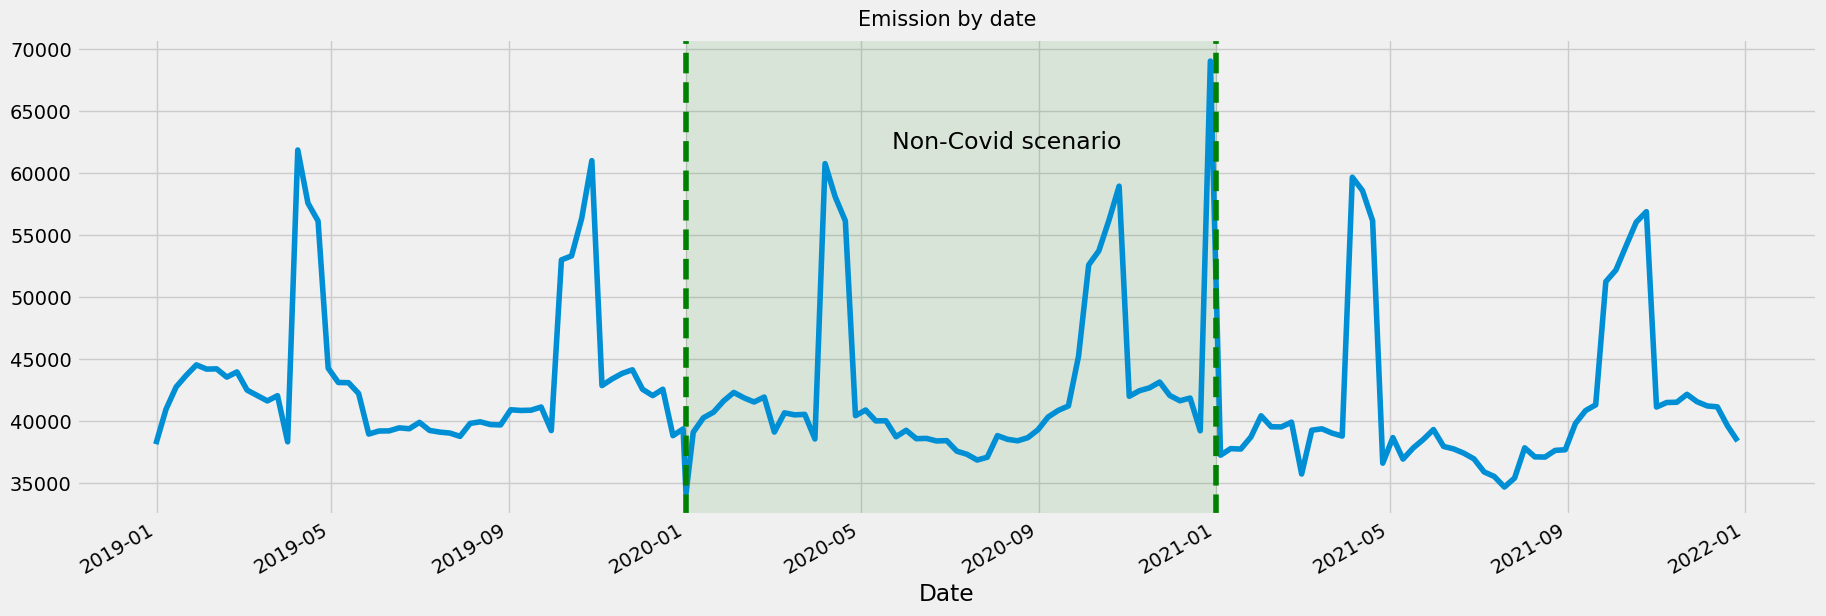

In [22]:
train.groupby(['date'])['emission'].sum().plot(kind='line', figsize=(20, 7), xlabel='Date')

plt.axvspan(pd.Timestamp('2020-01-01'), pd.Timestamp('2021-01-01'), color='green', alpha=0.1)
plt.axvline(pd.Timestamp('2020-01-01'), linestyle = "--", color='green')
plt.axvline(pd.Timestamp('2021-01-01'), linestyle = "--", color='green')

plt.text(pd.Timestamp('2020-05-22'), 62000, "Non-Covid scenario", size = 17)

plt.title('Emission by date', size=15, pad=10)
plt.show()

### There is an outlier at the last-week of 2020, the huge spike proves the same.

In [23]:
train.loc[(train['week_no'] == 52) & (train['year'] == 2020), 'emission'] = np.power(train.loc[(train['week_no'] == 52) & (train['year'] == 2020), 'emission'], 1/1.5)

### Season
Overall Rwanda's four climactic seasons are represented through the long rainy season: March to May, and short rainy season: September to November. These seasons alternate with the long dry season: June to August, and short dry season: December to February. Using this we will add season feature with seasons labeled from 1 to 4.

In [24]:
train['season'] = train['date'].dt.month.apply(lambda x: 1 if 3 <= x <= 5 else 2 if 6 <= x <= 8 else 3 if 9 <= x <= 11 else 4)

In [25]:
# Holidays:
train['holidays'] = (train['week_no'].isin([0, 51, 12, 30]))

# Cyclic features:
train['week_sin'] = np.sin(2 * np.pi * train['week_no']/53)
train['week_cos'] = np.cos(2 * np.pi * train['week_no']/53)

In [26]:
# Rotating location:
train['rot_15_x'] = (np.cos(np.radians(15)) * train['longitude']) + (np.sin(np.radians(15)) * train['latitude'])
train['rot_15_y'] = (np.cos(np.radians(15)) * train['latitude']) + (np.sin(np.radians(15)) * train['longitude'])
train['rot_30_x'] = (np.cos(np.radians(30)) * train['longitude']) + (np.sin(np.radians(30)) * train['latitude'])
train['rot_30_y'] = (np.cos(np.radians(30)) * train['latitude']) + (np.sin(np.radians(30)) * train['longitude'])

### Selecting features
We are using only a small subset of features.

In [27]:
from sklearn.cluster import KMeans
from haversine import haversine

avg_emissions_for_location = train.groupby(['latitude', 'longitude'], as_index=False)['emission'].mean()

num_clusters = 7
kmeans = KMeans(num_clusters, n_init = 'auto',random_state = 42).fit(avg_emissions_for_location)

# Each of 7 centers has 3 coordinates to describe it - lat, long and emission. But we only need lat and long to calculate distance.
centers = kmeans.cluster_centers_[:, :2]

# Get numpy array where i-th element is a cluster number for i-th location in our DataFrame
clusters = kmeans.predict(avg_emissions_for_location)

# For each location add cluster and its center coordinates 
avg_emissions_for_location["cluster"] = clusters
avg_emissions_for_location[["latitude_cluster", "longitude_cluster"]] = centers[clusters]

# Calculate distance from location to its cluster's center
highest_emission_location = avg_emissions_for_location.loc[avg_emissions_for_location['emission'].idxmax()]

avg_emissions_for_location['distance_to_max_emission'] = avg_emissions_for_location.apply(
    lambda x: haversine(
        (x['latitude'], x['longitude']),
        (highest_emission_location['latitude'],
         highest_emission_location['longitude'])),
    axis=1
)

# Each emission reading (row) from training set will now have its cluster and distance to cluster's center
# Clusters range from [0, 8]
train = train.merge(
    avg_emissions_for_location[['latitude', 'longitude', 'cluster', 'distance_to_max_emission']],
    on=['latitude', 'longitude'],
).set_index(train.index)

In [28]:
training_cols = ['latitude', 'longitude', 'year', 'week_sin', 'week_cos', 'holidays', 'rot_15_x', 'rot_15_y', 'rot_30_x', 'rot_30_y', 'distance_to_max_emission']

## Data Preprocessing

### Split Dataset:

In [29]:
X_train = train.drop(columns='emission')
y_train = train['emission']

### Creating a Pipepline

In [30]:
from sklearn.cluster import KMeans

pipeline = Pipeline([
        ('normalizer', Normalizer()),
        ('scaler', StandardScaler()),
        ('model', KMeans(n_clusters=7, n_init='auto', random_state=42))])

In [31]:
X_train = pipeline.fit_transform(X_train[training_cols])

In [32]:
X_train = pd.DataFrame(X_train, columns = pipeline.get_feature_names_out(), index=train.index)
X_train.head()

,kmeans0,kmeans1,kmeans2,kmeans3,kmeans4,kmeans5,kmeans6
0,5.091001,6.937009,4.695646,6.168722,6.797686,4.704932,3.869383
1,3.640272,5.793828,2.733925,4.876100,5.678353,2.864612,5.412122
2,3.640178,5.768000,2.678348,4.875546,5.705945,2.923176,5.410669
3,3.640003,5.741470,2.622582,4.874831,5.733749,2.979182,5.410898
4,3.639752,5.714605,2.567425,4.873967,5.761376,3.032004,5.412805


### Modelling

In [33]:
model = RandomForestRegressor(min_samples_leaf = 6, random_state = 42)
model.fit(X_train, y_train)

RandomForestRegressor(min_samples_leaf=6, random_state=42)

In [34]:
# 3 groups for 2019, 2020 and 2021
gkf = GroupKFold(3)

scores = -cross_val_score(model, X_train, y_train, scoring = "neg_root_mean_squared_error", cv = gkf.split(X_train, y_train, groups=train['year']))

print(f'Training RMSE: {mean_squared_error(y_train, model.predict(X_train), squared=False):.2f}')
print(f"Cross validation RMSE: {scores.mean():.2f}")

Training RMSE: 27.50
Cross validation RMSE: 97.56


### For submission, we will apply all steps on the "test" dataset, like we have done for the "train" data:

In [35]:
# Date
test['date'] = pd.to_datetime(test['year'].astype(str) + '-' + test['week_no'].astype(str) + '-1', format='%Y-%W-%w')

# Drop Uv Aerosol
test.drop(columns=['UvAerosolLayerHeight_aerosol_pressure', 'UvAerosolLayerHeight_solar_zenith_angle', 'UvAerosolLayerHeight_aerosol_height', 
                   'UvAerosolLayerHeight_aerosol_optical_depth', 'UvAerosolLayerHeight_sensor_zenith_angle', 'UvAerosolLayerHeight_sensor_azimuth_angle', 
                   'UvAerosolLayerHeight_solar_azimuth_angle'], inplace=True)

# Cyclic features
test['week_sin'] = np.sin(2 * np.pi * test['week_no']/53)
test['week_cos'] = np.cos(2 * np.pi * test['week_no']/53)

# Holidays
test['holidays'] = (test['week_no'].isin([0, 51, 12, 30]))

# Rotating location
test['rot_15_x'] = (np.cos(np.radians(15)) * test['longitude']) + (np.sin(np.radians(15)) * test['latitude'])
test['rot_15_y'] = (np.cos(np.radians(15)) * test['latitude']) + (np.sin(np.radians(15)) * test['longitude'])
test['rot_30_x'] = (np.cos(np.radians(30)) * test['longitude']) + (np.sin(np.radians(30)) * test['latitude'])
test['rot_30_y'] = (np.cos(np.radians(30)) * test['latitude']) + (np.sin(np.radians(30)) * test['longitude'])

# Clustering
test = test.merge(
    avg_emissions_for_location[['latitude', 'longitude', 'cluster', 'distance_to_max_emission']],
    on=['latitude', 'longitude'],
).set_index(test.index)

# Preprocess
X_test = pd.DataFrame(data=pipeline.transform(test[training_cols]), columns=pipeline.get_feature_names_out(), index=test.index)

In [40]:
sample_submission = pd.read_csv('/kaggle/input/playground-series-s3e20/sample_submission.csv', index_col='ID_LAT_LON_YEAR_WEEK')

for cluster in range(num_clusters):
    X_train_cluster = X_train[train['cluster'] == cluster]
    y_train_cluster = y_train[train['cluster'] == cluster]

    X_test_cluster = X_test[test['cluster'] == cluster]
    
    model = RandomForestRegressor(min_samples_leaf = 6, random_state= 42)
    model.fit(X_train_cluster, y_train_cluster)
    
    cluster_pred = model.predict(X_test_cluster)
    
    sample_submission.loc[list(test['cluster'] == cluster), 'emission'] = cluster_pred

In [43]:
sample_submission[sample_submission['emission'] < 0] = 0
sample_submission['emission'] *= 1.07 #from discussion: https://www.kaggle.com/competitions/playground-series-s3e20/discussion/428791

In [44]:
sample_submission.head()

,emission
ID_LAT_LON_YEAR_WEEK,
ID_-0.510_29.290_2022_00,3.440179
ID_-0.510_29.290_2022_01,5.063969
ID_-0.510_29.290_2022_02,5.063994
ID_-0.510_29.290_2022_03,5.097318
ID_-0.510_29.290_2022_04,5.135665


In [54]:
final_pred = pd.concat([test, sample_submission], axis=1)
final_pred.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,SulphurDioxide_solar_azimuth_angle,SulphurDioxide_solar_zenith_angle,SulphurDioxide_SO2_column_number_density_15km,CarbonMonoxide_CO_column_number_density,CarbonMonoxide_H2O_column_number_density,CarbonMonoxide_cloud_height,CarbonMonoxide_sensor_altitude,CarbonMonoxide_sensor_azimuth_angle,CarbonMonoxide_sensor_zenith_angle,CarbonMonoxide_solar_azimuth_angle,CarbonMonoxide_solar_zenith_angle,NitrogenDioxide_NO2_column_number_density,NitrogenDioxide_tropospheric_NO2_column_number_density,NitrogenDioxide_stratospheric_NO2_column_number_density,NitrogenDioxide_NO2_slant_column_number_density,NitrogenDioxide_tropopause_pressure,NitrogenDioxide_absorbing_aerosol_index,NitrogenDioxide_cloud_fraction,NitrogenDioxide_sensor_altitude,NitrogenDioxide_sensor_azimuth_angle,NitrogenDioxide_sensor_zenith_angle,NitrogenDioxide_solar_azimuth_angle,NitrogenDioxide_solar_zenith_angle,Formaldehyde_tropospheric_HCHO_column_number_density,Formaldehyde_tropospheric_HCHO_column_number_density_amf,Formaldehyde_HCHO_slant_column_number_density,Formaldehyde_cloud_fraction,Formaldehyde_solar_zenith_angle,Formaldehyde_solar_azimuth_angle,Formaldehyde_sensor_zenith_angle,Formaldehyde_sensor_azimuth_angle,UvAerosolIndex_absorbing_aerosol_index,UvAerosolIndex_sensor_altitude,UvAerosolIndex_sensor_azimuth_angle,UvAerosolIndex_sensor_zenith_angle,UvAerosolIndex_solar_azimuth_angle,UvAerosolIndex_solar_zenith_angle,Ozone_O3_column_number_density,Ozone_O3_column_number_density_amf,Ozone_O3_slant_column_number_density,Ozone_O3_effective_temperature,Ozone_cloud_fraction,Ozone_sensor_azimuth_angle,Ozone_sensor_zenith_angle,Ozone_solar_azimuth_angle,Ozone_solar_zenith_angle,Cloud_cloud_fraction,Cloud_cloud_top_pressure,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,date,week_sin,week_cos,holidays,rot_15_x,rot_15_y,rot_30_x,rot_30_y,cluster,distance_to_max_emission,emission
0,ID_-0.510_29.290_2022_00,-0.51,29.29,2022.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.561522,829937.000000,-100.113785,33.696957,-133.047562,33.779572,0.112175,2.374888,0.269846,227.193100,0.485340,-100.113785,33.696957,-133.047562,33.779572,0.485129,36022.027344,8472.313477,41047.937500,7472.313477,7.935617,0.240773,-100.113792,33.697044,-133.047546,33.779583,2021-12-27,0.000000,1.000000,True,28.15997,7.088188,25.110884,14.203327,0.0,207.84989,NaN
1,ID_-0.510_29.290_2022_01,-0.51,29.29,2022.0,1.0,0.000456,0.691164,0.000316,0.000000,76.239196,15.600607,-140.529848,28.896124,0.000157,0.037641,1688.656342,2814.309683,829652.957598,26.072167,25.189549,-142.612636,28.318923,0.000048,1.117653e-05,0.000037,0.000093,7311.869141,-1.416309,0.036769,829736.125000,76.239196,15.600607,-140.529848,28.896124,0.000123,0.957096,0.000058,0.000000,28.896124,-140.529848,15.600607,76.239196,-0.823662,829753.051343,-0.009998,34.745542,-139.171039,30.405075,0.112643,2.537305,0.290184,228.489219,0.515679,-0.009998,34.745542,-139.171039,30.405075,0.711262,48539.737242,6476.147323,54915.708579,5476.147161,11.448437,0.293119,-30.510319,42.402593,-138.632822,31.012380,2022-01-03,0.118273,0.992981,False,28.15997,7.088188,25.110884,14.203327,0.0,207.84989,NaN
2,ID_-0.510_29.290_2022_02,-0.51,29.29,2022.0,2.0,0.000161,0.605107,0.000106,0.079870,-42.055341,39.889060,-136.908976,30.054682,0.000053,0.037795,2629.692089,3233.654973,829589.971617,14.881259,40.833582,-143.949340,26.760219,0.000055,1.679787e-05,0.000038,0.000109,8613.426417,-0.008104,0.036490,8299

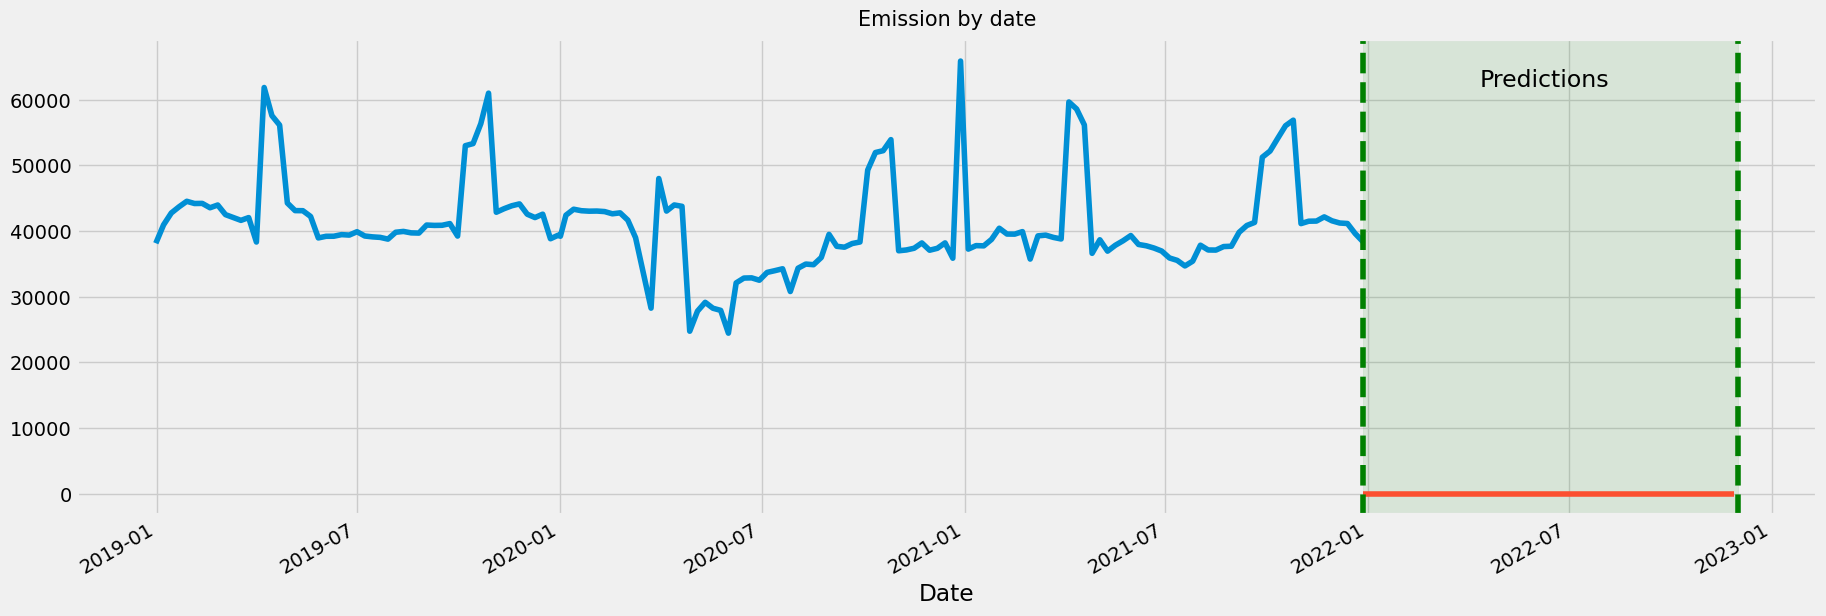

In [55]:
train_plot.groupby(['date'])['emission'].sum().plot(kind='line', figsize=(20, 7), xlabel='Date')
final_pred.groupby(['date'])['emission'].sum().plot(kind='line', figsize=(20, 7), xlabel='Date')

plt.axvspan(pd.Timestamp('2021-12-27'), pd.Timestamp('2022-12-01'), color='green', alpha=0.1)
plt.axvline(pd.Timestamp('2021-12-27'), linestyle = "--", color='green')
plt.axvline(pd.Timestamp('2022-12-01'), linestyle = "--", color='green')

plt.text(pd.Timestamp ('2022-04-12'), 62000, "Predictions", size = 17)

plt.title('Emission by date', size=15, pad=10)
plt.show()

In [56]:
sample_submission.to_csv('/kaggle/working/submission.csv')

# Acknowledgements:
1. https://www.kaggle.com/code/kacperrabczewski/rwanda-co2-step-by-step-guide
2. https://www.kaggle.com/code/nazimcherpanov/accurate-solution-easy-to-understand-xgboost/notebook
3. https://www.kaggle.com/competitions/playground-series-s3e20/discussion/428791

# This notebook needs suggestions to improve, from other contributors.